# Aligning audio files

I have been working on a project called Choirless (https://youtu.be/GpkkwptB0y8) which allows 
people to sing and play music together despite being remote.

One of the main requirements is to be able to synchronise multiple audio tracks from 
the different performers to a reference track. Whilst we attempt to start recording all
at the same time, due to delays in the operating system and browsers there is often a slight
delay. So we need to process the audio files to try and calculate and remove that slight delay.

In this notebook we look at one way of doing this, utilising some functions from `librosa` to find
the peaks in the audio and a custom function to allow us to do fuzzy matching of the signals to
find the best fit.

In [1]:
# Install librosa via conda.
# !conda install -c conda-forge librosa
# alternative method:
# !pip install librosa 


In [2]:
import numpy as np
import IPython.display as ipd
import librosa
from six.moves.urllib.request import urlopen
import io

SAMPLE_RATE = 44100
cos_url = "https://cos-matth-cos-public.s3.eu-gb.cloud-object-storage.appdomain.cloud/"

# load in the leader
x0, fs0 = librosa.load(io.BytesIO(urlopen(cos_url + "leader.wav").read()), 
                       sr=SAMPLE_RATE, mono=True, offset=10, duration=10)

# load in sarah
x1, fs1 = librosa.load(io.BytesIO(urlopen(cos_url + "sarah1.wav").read()), 
                       sr=SAMPLE_RATE, mono=True, offset=10, duration=10)

In [3]:
ipd.Audio(x0, rate=fs0)

In [4]:
ipd.Audio(x1, rate=fs1)

In [5]:
print(x0.shape)
print(x1.shape)

(441000,)
(441000,)


In [6]:
# Normalise the two signals so that they are the same average amplitude (volume)
x0 = (x0 - np.mean(x0)) / np.std(x0)
x1 = (x1 - np.mean(x1)) / np.std(x1)

In [7]:
# Mix them together. Have a listen, you can hear Sarah's
# recording is slightly delayed
ipd.Audio(x0 * 0.5 + x1 * 0.5, rate=fs1)

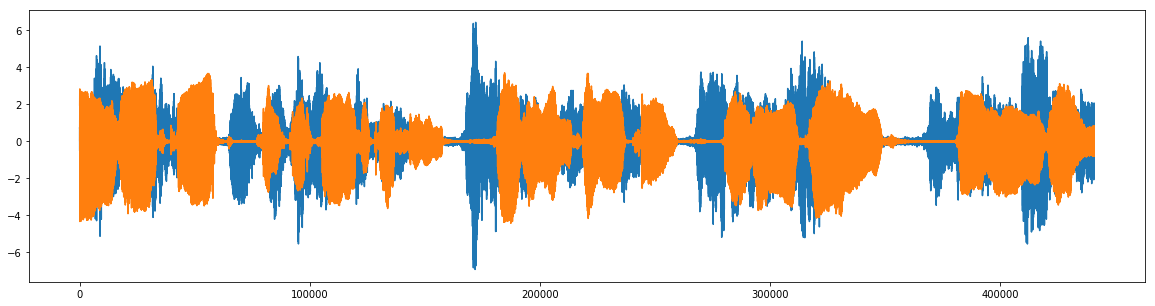

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

# Plot the audio waveforms just to see what they look like
plt.figure(figsize=[20,5])
plt.plot(x0)
plt.plot(x1)

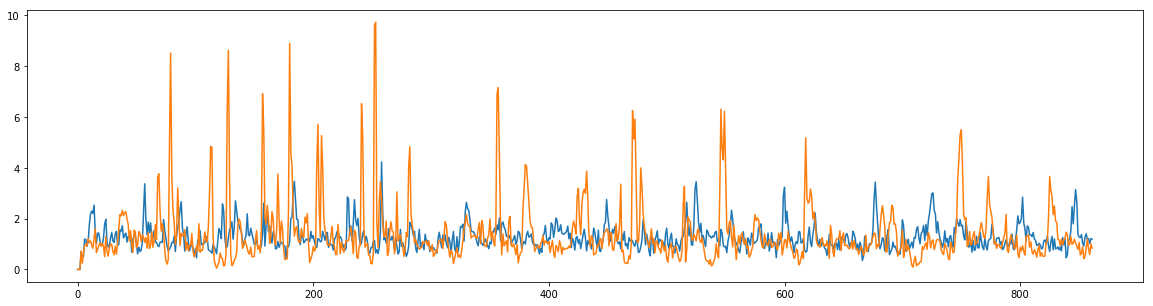

In [9]:
# Calculate the 'onset strength' of the files, ie where parts start
o0 = librosa.onset.onset_strength(x0, sr=fs0)
o1 = librosa.onset.onset_strength(x1, sr=fs1)

# Plot the onset strenths to see what they look like
plt.figure(figsize=[20,5])
plt.plot(o0)
plt.plot(o1)

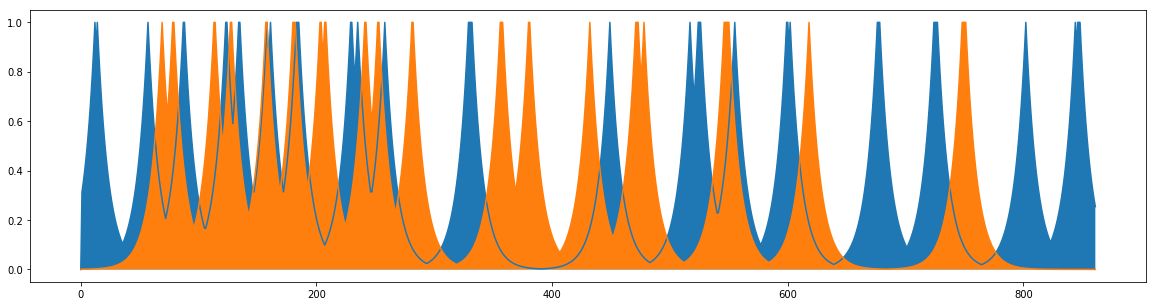

In [10]:
import numpy as np

# function to process the signals and get something that 
# we can compare against each other.
def process_signal(o):
    # normalise the values (zscore)
    o = (o - np.mean(o)) / np.std(o)
    # take any values > 2 standard deviations
    o = np.where(o > 2, 1.0, 0.0)
    
    # add an 'decay' to the values such that we can do a more 'fuzzy' match
    # forward pass
    for i in range(1, len(o)):
        o[i] = max(o[i], o[i-1] * 0.9)
        
    # backwards pass
    for i in range(len(o)-2, 0, -1):
        o[i] = max(o[i], o[i+1] * 0.9)
    
    return o

# process the signal of the leader and sarah
s0 = process_signal(o0)
s1 = process_signal(o1)

# plot them to see what they look like
plt.figure(figsize=[20,5])
plt.plot(s0)
plt.fill_between(range(len(s0)), s0)
plt.plot(s1)
plt.fill_between(range(len(s1)), s1)


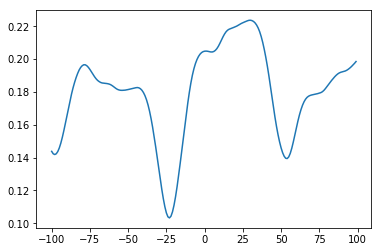

In [11]:
# function to measure two waveforms with one offset by a certian amount
def measure_error(x0, x1, offset):
    max_len = min(len(x0), len(x1))
    
    # calculate the mean squared error of the two signals
    diff = x0[:max_len] - np.roll(x1[:max_len], offset)
    err = np.sum(diff**2) / len(diff)
    return err

# consider offsets of -100 to 100 of the original
offsets = tuple(range(-100, 100))
# calculate the errors of each one
errors = [ measure_error(s0, s1, offset) for offset in offsets ]
    
# plot the errors against offset so we can see what it looks like
# we are looking to see a minimum, where the signals best match up
plt.plot(offsets, errors)

In [12]:
# Find the offest with the lowest error       
def find_offset(x0, x1):
    offsets = tuple(range(-100, 100))
    errors = [ (measure_error(x0, x1, offset), offset) for offset in offsets ]
    
    error, offset = sorted(errors)[0]
                     
    return offset, error

offset, error = find_offset(s0, s1)

# convert the offsets to milliseconds when we print the best
print(f"Best offset: {((offset * 512) / SAMPLE_RATE) * 1000} ms error {error}")
    

Best offset: -267.0294784580499 ms error 0.10321377087414048


## The Final Result

In [13]:
# Offset Sarah's audio by the offset above to bring it forward slightly
x1b = np.roll(x1, offset * 512)

# Listen to the final output. They are in time!
ipd.Audio(x0 * 0.5 + x1b * 0.5, rate=fs1)